# IK Speeches Rhetorical Analysis And Model Building

## About Dataset

This dataset compiles 67 speeches delivered by Imran Khan, former Prime Minister of Pakistan, across various events, both domestic and international. The speeches cover a wide range of topics, including governance, foreign policy, welfare, economic development, and the socio-political landscape of Pakistan.

## Introduction - What To Expect

This notebook explores the speeches of Imran Khan, the former Prime Minister of Pakistan, from a data science perspective. The key objectives include:

* **Preprocessing** textual data for natural language processing (NLP) tasks.
* Building **topic models** to discover latent topics in the speeches.
* Conducting **sentiment analysis** to gauge the emotional tone of the speeches.
* Performing **lexical diversity** analysis to study the richness of vocabulary.
* **Visualizations** with each analysis.

## Imports

In [1]:
from gensim.models import TfidfModel, CoherenceModel, Phrases, LdaModel # for training and evaluating lDA model
from nltk.sentiment import SentimentIntensityAnalyzer # sentiment analysis
import pyLDAvis.gensim_models as gensimvis # visualizing lda topics
from gensim.corpora import Dictionary # for LDA model
from collections import defaultdict
from nltk.corpus import stopwords
import matplotlib.pyplot as plt # visulaizations
from wordcloud import WordCloud # visualizations
from itertools import product
from textblob import TextBlob # sentiment analysis
from copy import deepcopy
import seaborn as sns # visulaizations
import pandas as pd
import pyLDAvis # visualizing lda topics
import string # removing punctuation marks from speeches
import spacy # text processing
import nltk # text processing
import re

!pip install lexical_diversity > /dev/null 2>&1
from lexical_diversity import lex_div as ld

print("Imports Successfull")

# loads the english dictionary "small" model in memory to start text processing
nlp = spacy.load("en_core_web_sm")
SEED = 123

data_file = r"/kaggle/input/imran-khans-speeches/PM Imran Khan 67 speeches.txt"

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Imports Successfull


## Load Data

In [2]:
df = pd.read_csv(data_file, parse_dates=['Date'])

display(df.head())

display(df.info())

,Date,Title,Content
0,2021-12-19,PM Imran Khan Address OIC Summit 2021 19 12 ...,\r\n\r\n[general] respected foreign ministers ...
1,2021-08-02,PM Imran Khan Addresses Three-Day Exhibition a...,\r\n\r\n1. [general] That this alarm is in adv...
2,2020-11-19,PM Imran Khan and Afghan President Ashraf Ghan...,\r\n\r\n[general] [governance] mr prime mini...
3,2019-11-26,PM IMRAN KHAN ADDRESSES EHSAAS ECONOMIC PARTNE...,\r\n\r\n[general] azam Imran Khan kitab garaje...
4,2021-04-21,PM Imran Khan Addresses Inauguration Ceremony ...,\r\n\r\n[general] Pushp Alarm 150 Hai Yeh Song...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     67 non-null     datetime64[ns]
 1   Title    67 non-null     object        
 2   Content  67 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ KB


None

## Text Cleaning

### Convert Data In Proper Format

* Reading the `txt` file directly, also causes the *new-line* and *carriage-return* characters to display in the content of speeches. So let's use the `re` module to remove such characters from the `Content`.

* Moreover the `Title` column contains dates for each speech which is redundant, since we already have a separate `Date` column which records date for each speech. We can once again use `re` module for this task.

* After extracting the *date* and *year* attributes from the `Date` column, let's convert all the column names to lowercase. This ensures consistency and plus it's easier to write column names that way.

In [3]:
# remove carriage-return and new-line characters from Content
df["Content"] = [re.sub(r"\r\n", "", text) for text in df["Content"]]

# remove dates from the Title column
df["Title"] = [re.sub(r"\d+", "", text) for text in df.Title]

# extract date and year attributes
df["year"] = df["Date"].dt.year
df["Date"] = df["Date"].dt.date

df.columns = [col.lower() for col in df.columns]

display(df.head())

,date,title,content,year
0,2021-12-19,PM Imran Khan Address OIC Summit,[general] respected foreign ministers ladies a...,2021
1,2021-08-02,PM Imran Khan Addresses Three-Day Exhibition a...,1. [general] That this alarm is in advance tha...,2021
2,2020-11-19,PM Imran Khan and Afghan President Ashraf Ghan...,[general] [governance] mr prime minister you...,2020
3,2019-11-26,PM IMRAN KHAN ADDRESSES EHSAAS ECONOMIC PARTNE...,[general] azam Imran Khan kitab garaje Abu Duc...,2019
4,2021-04-21,PM Imran Khan Addresses Inauguration Ceremony ...,[general] Pushp Alarm 150 Hai Yeh Song Bhaiya ...,2021


## Sneak Peek - Speeches Per Year

Now that we have the year recorded against each speech let's take a look at the number of speeches given by the former PM over the years.

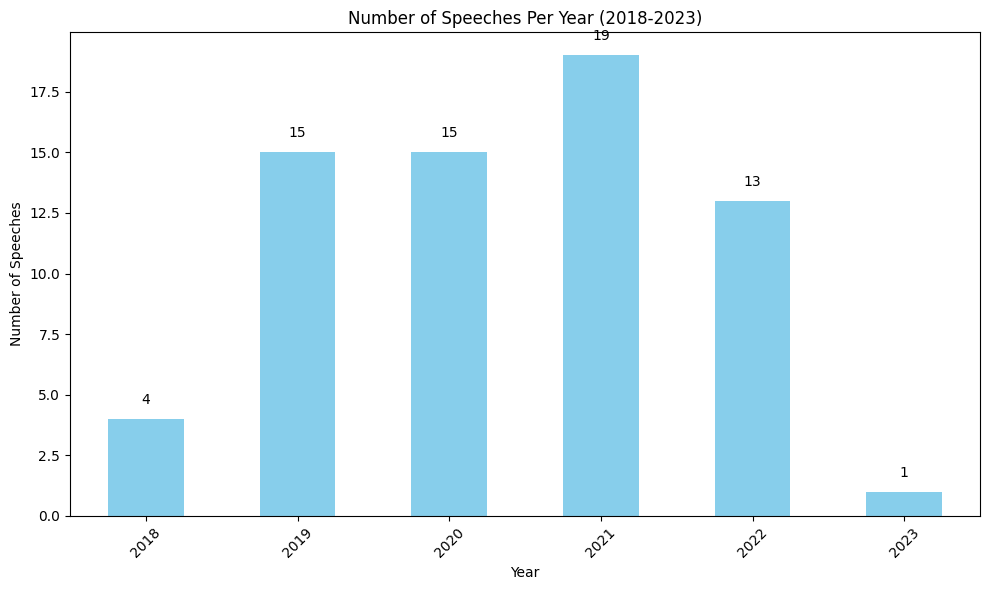

In [4]:
# Code copied from Kamran Ali's notebook
# https://www.kaggle.com/code/whisperingkahuna/speeches-rhetorical-analysis

speeches_per_year = df['year'].value_counts().sort_index()
# Plot the results
plt.figure(figsize=(10, 6))
ax = speeches_per_year.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Number of Speeches Per Year (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')

# Add count annotations on top of bars
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.5,  # Position of text
            str(int(i.get_height())),  # Text (the count)
            ha='center', va='bottom', fontsize=10, color='black')  # Formatting

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## Data Preprocessing

Now that we have the data in proper format we can preprocess it and prepare it for further analysis and model building.

* To prepare the data for `Topic Modeling` i.e `LDA` model, first let's remove all the **speech annotations** from the `content` column and save the speeches in a **new column** `processed_content`.

* Next up, we need to create a *string translation* table which will remove all **punctuation marks** from the speeches.

* Upon inspecting one of the speeches I noticed some words which were **alpha-numeric** e.g: "sto123". These words are of no use so let's remove them using a regex expression. 

* After converting the text to **lowercase** and removing **extra whitespaces** I removed all the `stopwords` from the speeches.

These preprocessing steps provide a **good base** for building a model allowing us to move to the next step.

In [5]:
# remove speech annotations delimited by square brackets e.g: [general], and create new column
df["processed_content"] = [re.sub(r'\[\w+\]', '', text) for text in df["content"]]

# replace punctuation marks with a single whitespace
table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

for n, row in df.iterrows():
    df.loc[n, "processed_content"] = df["processed_content"][n].translate(table)

# remove words which ara alpha-numeric
df["processed_content"] = [re.sub(r'\b[a-zA-z]+\d+[a-zA-z]*\b', "", text) 
                               for text in df["processed_content"]]

# convert content to lowercase
df["processed_content"] = df["processed_content"].apply(str.lower)

# replace more than one whitespace characters with a single whitespace
df["processed_content"] = [re.sub(r'\s+', ' ', text).strip() 
                               for text in df["processed_content"]]

stoplist = set(stopwords.words("english"))

def remove_stopwords(text):
    cleaned_text = [word for word in text.split() if word not in stoplist]
    
    return " ".join(cleaned_text)

# remove stopwords
df["processed_content"] = df["processed_content"].apply(remove_stopwords)

display(df.head())

,date,title,content,year,processed_content
0,2021-12-19,PM Imran Khan Address OIC Summit,[general] respected foreign ministers ladies a...,2021,respected foreign ministers ladies gentlemen f...
1,2021-08-02,PM Imran Khan Addresses Three-Day Exhibition a...,1. [general] That this alarm is in advance tha...,2021,1 alarm advance head rawalpindi chamber commer...
2,2020-11-19,PM Imran Khan and Afghan President Ashraf Ghan...,[general] [governance] mr prime minister you...,2020,mr prime minister coming historic common objec...
3,2019-11-26,PM IMRAN KHAN ADDRESSES EHSAAS ECONOMIC PARTNE...,[general] azam Imran Khan kitab garaje Abu Duc...,2019,azam imran khan kitab garaje abu ducati fortun...
4,2021-04-21,PM Imran Khan Addresses Inauguration Ceremony ...,[general] Pushp Alarm 150 Hai Yeh Song Bhaiya ...,2021,pushp alarm 150 hai yeh song bhaiya satta king...


## Topic Modeling with LDA

### Tokenization and Lemmatization

Let's prepare the data for **topic modeling**. To achieve this:

* First let's **tokenize** the words in each speech for further processing. For this we can pass the text to *spacy's english model*. 

*  Generally we want to remove tokens with less than 2 characters, but I removed all tokens which were **less than 3 characters** e,g: 'add', 'low', etc. It's a matter of choice and can be experimented with.

* Let's also remove the tokens which spacy could not interpret as **english** words or were not purely **alphabetical**.

* Finally let's reduce the tokens to their **lemma** or root form, and save the content in a new column `tokenized_content`.

In [6]:
def tokenize_content(text):
    speech = nlp(text) # tokenization

    tokens = [] # list to store valid tokens
    
    for token in speech:
        # check for valid tokens
        if len(token.text) <= 3 or not token.is_alpha or not token.lang_ == "en":
            continue # not valid - skip and do not append 
        else:
            tokens.append(token)
    
    # lemmatization
    tokens = [token.lemma_ for token in tokens]
    
    return tokens

df["tokenized_content"] = df["processed_content"].apply(tokenize_content)

display(df.head())

,date,title,content,year,processed_content,tokenized_content
0,2021-12-19,PM Imran Khan Address OIC Summit,[general] respected foreign ministers ladies a...,2021,respected foreign ministers ladies gentlemen f...,"[respect, foreign, minister, lady, gentleman, ..."
1,2021-08-02,PM Imran Khan Addresses Three-Day Exhibition a...,1. [general] That this alarm is in advance tha...,2021,1 alarm advance head rawalpindi chamber commer...,"[alarm, advance, head, rawalpindi, chamber, co..."
2,2020-11-19,PM Imran Khan and Afghan President Ashraf Ghan...,[general] [governance] mr prime minister you...,2020,mr prime minister coming historic common objec...,"[prime, minister, come, historic, common, obje..."
3,2019-11-26,PM IMRAN KHAN ADDRESSES EHSAAS ECONOMIC PARTNE...,[general] azam Imran Khan kitab garaje Abu Duc...,2019,azam imran khan kitab garaje abu ducati fortun...,"[azam, imran, khan, kitab, garaje, ducati, for..."
4,2021-04-21,PM Imran Khan Addresses Inauguration Ceremony ...,[general] Pushp Alarm 150 Hai Yeh Song Bhaiya ...,2021,pushp alarm 150 hai yeh song bhaiya satta king...,"[pushp, alarm, song, bhaiya, satta, king, toda..."


### Bigrams and Dictionary

To achieve a better score on topic modelling we need to:

* Identify **bigrams** e.g: 'prime_minister', etc in each speech, instead of treating them as individual words i.e: 'prime', and 'minister'.

* In the context of this problem we add a bigram only if it's **min_count** is 50 i.e: the word appears at least 50 times in the content to be considered valid.

* Finally let's pass the `tokenized_content` to the gensim's `Dictionary` object. This will create a dictionary of all the **unique** words across all the speeches.

In [7]:
# store all 67 speeches in a variable
speeches = df["tokenized_content"].values

# Bigram object
bigram = Phrases(speeches, min_count=50)

for i in range(len(speeches)):
    for token in bigram[speeches[i]]:
        if '_' in token:
            # Token is a bigram, so add it.
            speeches[i].append(token)

# Dictionary object - Particular variable name chosen cuz we'll reference it again and again
org_dictionary = Dictionary(speeches)

print(org_dictionary)

Dictionary<7391 unique tokens: ['ability', 'action', 'adjoin', 'afan', 'afghan']...>


### Building the LDA Model

`Dictionary` object, maps each unique word to a numeric ID, and is essential in topic modeling. To start *builiding the model* we need to perform a couple of steps which include:

1. Filtering **extreme values** from the `Dictionary` object.

2. Creating **corpus of words** to convert text into numerical representation.

    * Initially, we convert to **bag of words** which, represents text by counting the occurrences of each word in a document (speech), ignoring grammar and word order.
    
    * Later we can convert from bag of words to **TF-IDF** which,  represents text by assigning each word a *weight* based on its frequency in a document (speech) and its inverse frequency across all documents (speeches), highlighting important words.
    
    * Building the LDA model on two different numerical representations will allow us to determine which approach **best represents** our data.
    
3. **Training** and **evaluating** the LDA model.

    * For evaluation we use two metrics **coherence** and **perplexity**.
    
    * Generally, we aim for **lower perplexity** scores, and **high coherence** scores.

Note: The *docstring* for each function is not written in the traditional format, and contains only the info which I assumed would be necessary to explain its working.

In [8]:
def filter_dictionary(org_dict, no_below=None, no_above=None):
    """   
    This function is used to filter words in the dictionary before training an LDA model by 
    removing infrequent or overly common words, which can help improve the topic model's performance.

    Filters a Gensim Dictionary object by removing words that appear in less than a specified number
    of documents (`no_below`) or in more than a specified proportion of documents (`no_above`).
    """
    # copy of the original dictionary to avoid making any changes to it
    words_dict = deepcopy(org_dict)

    if no_below == None or no_above == None:
        return words_dict # do not filter - return unchanged
    else:
        words_dict.filter_extremes(no_below=no_below, no_above=no_above)
        return words_dict

    
def create_corpus(words_dict, speeches, tfidf_model=False):
    """    
    Converts a collection of documents or speeches in this context into a numerical representation 
    (bag-of-words or TF-IDF) using a Gensim Dictionary object.

    This function creates a numerical corpus representation, which can be used as input for topic 
    modeling using LDA. It supports both bag-of-words and TF-IDF transformations,
    depending on the `tfidf_model` flag.
 
    Returns:
    
    list of list of (int, int): A corpus where each speech is represented as a list of tuples. 
    Each tuple contains a word's ID and its frequency in the document. 
    If `tfidf_model` is True, the tuples represent word ID and TF-IDF scores instead of raw counts.
    """
    # convert each speech into bag of words numerical representation
    corpus = [words_dict.doc2bow(speech) for speech in speeches]

    # If true then further convert from bow to tfidf representation
    if tfidf_model:
        tfidf = TfidfModel(corpus) # train tfidf model on corpus
        corpus = tfidf[corpus] # transform corpus into tdidf
    
    return corpus
    

def lda_model(corpus, num_topics, words_dict, random_state=SEED):
    """    
    Trains an LDA (Latent Dirichlet Allocation) topic model using a given corpus and words dictionary.

    This function trains an LDA model to discover latent topics within a collection of documents
    or speeches in this context. It allows fine-tuning of the model using parameters such as the
    number of topics, the number of passes through the corpus, and the number of
    iterations for training.
    """
    # model parameters
    num_topics = num_topics
    chunksize = 70
    passes = 50
    iterations = 400
    eval_every = None

    temp = words_dict[0] # loads the dictionary
    id2word = words_dict.id2token

    # train the model
    model = LdaModel (
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state=random_state
    )
    
    return model

def evaluate_model(model, corpus, words_dict, speeches, coherence='c_v'):
    """
    Evaluates an LDA model using coherence and perplexity metrics.

    This function evaluates the quality of an LDA model by computing two key metrics: 
    coherence, which indicates the semantic consistency of topics, and perplexity, which measures 
    how well the model fits the corpus data. 
    
    Higher coherence score and lower perplexity score indicate a good fit for the model.
    """
    coherence_model_lda = CoherenceModel(model=model, texts=speeches, 
                                         dictionary=words_dict, coherence=coherence)
    coherence_score = coherence_model_lda.get_coherence()
    
    model_perplexity = model.log_perplexity(corpus)
    
    return coherence_score, model_perplexity

### Training LDA Model

Let's move to **training** the LDA model. To find the **optimal hyperparameters** for the model we will:

* Define a `params_grid` which will have different values for various *hyperparameters*

* Train **multiple LDA models** on a combination of hyperparameters. To achive this I've defined a function "train_model".

*Note: This function returns the last trained model and its associated corpus, and dictionary when training multiple models with a combinaation of hyperparameters. Once the best hyperparameters are identified, a single model is trained for further analysis.*


In [9]:
# Define the hyperparameter grid for finding the optimal model configuration
params_grid = {
    "num_topics" : [5, 10],
    "no_below" : [20, 30],
    "no_above" : [None, .5, .8]
}

combinations = list(product(params_grid["num_topics"], 
                                params_grid["no_below"], 
                                params_grid["no_above"]))

print(f"Total Combinations: {len(combinations)}")
print(f"\nFirst 3 combinations are {combinations[:3]}")

Total Combinations: 12

First 3 combinations are [(5, 20, None), (5, 20, 0.5), (5, 20, 0.8)]


In [10]:
def train_model(org_dictionary, speeches, combinations, tfidf_model=False, random_state=SEED):
    """    
    Trains multiple LDA models based on different parameter combinations and evaluate each model's performance.

    This function trains multiple LDA models based on different topic numbers and dictionary 
    filtering criteria. It evaluates each model using coherence and perplexity scores, returning 
    the trained model and its corresponding corpus, dictionary, and evaluation results. 
    This allows for systematic tuning of hyperparameters to find the optimal model configuration.
    """
    results = []
    
    for num_topics, no_below, no_above in combinations:
        words_dict = filter_dictionary(org_dictionary, no_below, no_above)

        corpus = create_corpus(words_dict, speeches, tfidf_model=tfidf_model)

        model = lda_model(corpus, num_topics, words_dict, random_state=random_state)

        coherence, perplexity = evaluate_model(model, corpus, words_dict, speeches)
        
        result = {
            'coherence_score': coherence,
            'perplexity_score': perplexity,
            "num_topics" : num_topics,
            "no_below" : no_below,
            "no_above" : no_above
        }
        
        results.append(result)
    return model, corpus, words_dict, results

In [11]:
# since we only need to see the performance of models right now let's discard other variables
_, __, ___, bow = train_model(org_dictionary, speeches, combinations)
_, __, ___, tfidf = train_model(org_dictionary, speeches, combinations, tfidf_model=True)

### Finding the Optimal Model Hyperparameters

#### Visualizing Model Results

Now that we have the evaluation results of lda models against a variety of hyperparameter combinations we can find the **optimal model configuration**. To do this:

* Let's visualize the results of each *numeriacal representation* of text and see which conversion performs better.

In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [13]:
# Create dataframes from evaluation results of each representation
# Add an index column to the dataframes
results_bow = pd.DataFrame(bow).reset_index()
results_tfidf = pd.DataFrame(tfidf).reset_index()

# Let's combine the results into a single dataframe
results_df = results_bow.join(results_tfidf, on="index", how="inner",
                          lsuffix='_bow', rsuffix='_tfidf')

display(results_bow.head(2))
display(results_tfidf.head(2))

display(results_df.head(2))

,index,coherence_score,perplexity_score,num_topics,no_below,no_above
0,0,0.310033,-7.489322,5,20,NaN
1,1,0.381020,-5.166786,5,20,0.5


,index,coherence_score,perplexity_score,num_topics,no_below,no_above
0,0,0.607248,-10.788779,5,20,NaN
1,1,0.213078,-5.970507,5,20,0.5


,index,index_bow,coherence_score_bow,perplexity_score_bow,num_topics_bow,no_below_bow,no_above_bow,index_tfidf,coherence_score_tfidf,perplexity_score_tfidf,num_topics_tfidf,no_below_tfidf,no_above_tfidf
0,0,0,0.310033,-7.489322,5,20,NaN,0,0.607248,-10.788779,5,20,NaN
1,1,1,0.381020,-5.166786,5,20,0.5,1,0.213078,-5.970507,5,20,0.5


In [14]:
def display_results(df, col1, col2, c1, c2):
    """    
    Displays a comparison of two metrics (coherence and perplexity) over model variations
    using a dual-axis line plot.
    
    This function visualizes the coherence and perplexity scores of LDA models by plotting them
    on separate y-axes but sharing the same x-axis (model index). It helps compare the two metrics
    side by side to evaluate model performance. The title of the plot is dynamically generated 
    based on whether the model uses the Bag of Words or TF-IDF approach.
    """
    # Create a figure and axis
    fig, ax = plt.subplots()
    col1_label = col1.replace("_", " ").title()
    col2_label = col2.replace("_", " ").title()
    
    # Plot coherence score on the first y-axis
    ax.plot(df.index, df[col1], color=c1, label=col1_label)
    ax.set_xlabel('Hyperparameter Combination Index')
    ax.set_ylabel(col1_label, color=c1)
    ax.tick_params(axis='y', labelcolor=c1)

    # Create a second y-axis to plot the perplexity
    ax2 = ax.twinx()
    ax2.plot(df.index, df[col2], color=c2, label=col2_label)
    ax2.set_ylabel(col2_label, color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)

    # Title and show the plot
    if "Bow" in col1_label:
        plt.title('Coherence and Perplexity Scores Using Bag of Words Approach')
    else:
        plt.title('Coherence and Perplexity Scores Using TfIdf Vectorizer Approach')

    fig.tight_layout()
    plt.show()

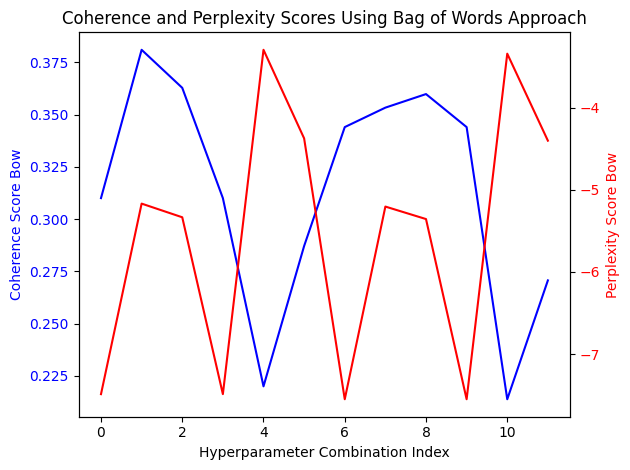

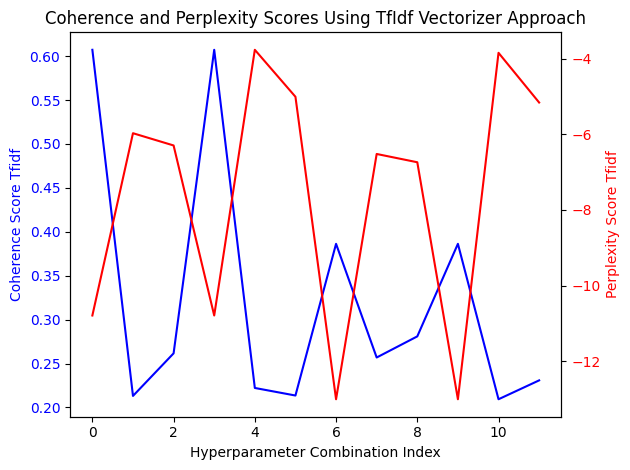

In [15]:
display_results(results_df, "coherence_score_bow", "perplexity_score_bow", "blue", "red")

display_results(results_df, "coherence_score_tfidf", "perplexity_score_tfidf", "blue", "red")

#### Optimal Parameters

Displaying the results of training multiple LDA models on a combination of hyperparameters, reveals interesting **insights**.

* Overall, creating the **corpus** using **TF-IDF** conversion, results in better evaluation scores across both metrics.

* When converting text using the **bag of words** approach, the **optimal hyperparameter** combination is at *index 9*. For these hyperparameters the coherence and perplexity scores are approximately 0.35 and -7 respectively.

* When converting text using the **TF-IDF** approach, the **optimal hyperparameter** combination is at *index 3*. For these hyperparameters the coherence and perplexity scores are approximately 0.60 and -11 respectively.

### Training and Visualizng the Optimal Model

Now that we know the best hyperparameters, we can index combinations list and train our model using optimal configuration.

In [16]:
best_params = []
best_params.append(combinations[3])

print(f"Best Parameters For LDA Model: {best_params}")

# This time we don't need the results dictionary so let's discard it
model, corpus, words_dict, _ = train_model(org_dictionary, speeches,
                                                             best_params, tfidf_model=True)

Best Parameters For LDA Model: [(5, 30, None)]


In [17]:
# Prepare the visualization
lda_display = gensimvis.prepare(model, corpus, words_dict)

# Show the visualization
pyLDAvis.display(lda_display)

## WordCloud for Topics Identified by LDA

To visulaize the **topics** identified by LDA model we will:

* First **extract** all the topics from model objext by calling the `show_topics` function.

* Create a dictionary which will add the **frequency** of each topic.

* Use `WordCloud` to to visualize the frequencies of each topic.

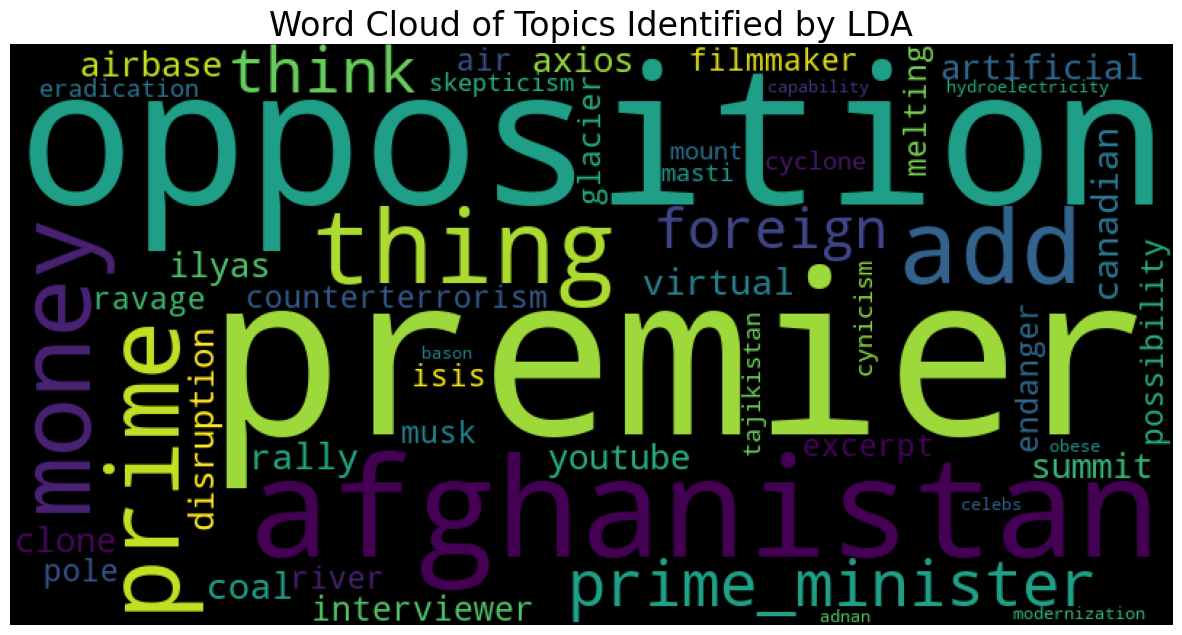

In [18]:
# Get topics from the LDA model
topics = model.show_topics(num_topics=5, formatted=False)

# word frequencies from all topics
word_freqs = defaultdict(float)

for topic_num, list_topics in topics:
    for topic, freq in list_topics:
        word_freqs[topic] += freq  # add the frequency from each topic

plt.figure(figsize=(15, 8))

cloud = WordCloud(width=800, height=400, background_color="black", random_state=SEED)\
                 .generate_from_frequencies(word_freqs)

# Plot the word cloud
plt.imshow(cloud)
plt.axis("off")
plt.title("Word Cloud of Topics Identified by LDA", fontsize=24)
plt.show()

## Sentiment Analysis

Let's perform sentiment analysis to gauge the emotional tone of the speeches. We will use two different approaches namely:

* `TextBlob`: The get_sentiment function computes the sentiment polarity of each processed speech.

* `VADER (SentimentIntensityAnalyzer)`: For each speech, VADER assigns scores for negative, neutral, positive, and compound sentiments.

After performing sentiment analysis using these two techniques, we combie their results in a dataframe and rename the columns for clarity.

In [19]:
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment

blob_sentiment = df["processed_content"].apply(get_sentiment)

In [20]:
sia = SentimentIntensityAnalyzer()
vader_results_dict = {}

for i, row in df.iterrows():
    text = row["processed_content"]
    vader_results_dict[i] = sia.polarity_scores(text)

In [21]:
# combine the results of sentiment-analysis
sentiment_results = pd.DataFrame(vader_results_dict).T

# rename the columns to associate scores with the respective approach
sentiment_results.columns = ["vader_neg", "vader_neu", "vader_pos", "vader_compound"]

# add results from textblob
sentiment_results["blob_sentiment"] = blob_sentiment

# add year column
sentiment_results["year"] = df["year"].values
sentiment_results = sentiment_results.reset_index()

display(sentiment_results.head())

,index,vader_neg,vader_neu,vader_pos,vader_compound,blob_sentiment,year
0,0,0.176,0.673,0.151,-0.9927,0.033286,2021
1,1,0.079,0.762,0.159,0.9989,0.077961,2021
2,2,0.128,0.580,0.292,0.9980,0.081144,2020
3,3,0.168,0.612,0.220,0.9910,0.100415,2019
4,4,0.088,0.680,0.232,0.9987,0.213556,2021


### Visualizing the Sentiment

To gauge the emotional tone used in the speeches let's visualize them:

* **Bar Plot (TextBlob Sentiment)**: Displays the average polarity score (sentiment) estimated by TextBlob for each year, giving insights into overall sentiment shifts.

* **Line Plot (VADER Sentiment)**: Plots both positive and negative sentiment scores (VADER) over the years, helping to compare sentiment polarity and track changes across time.


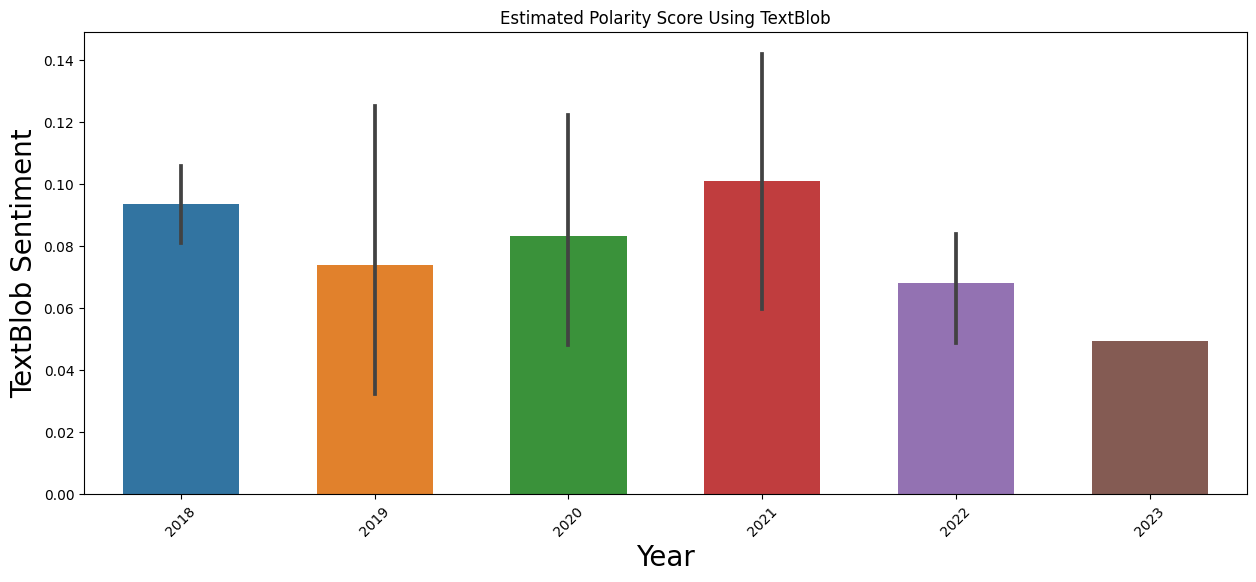

In [22]:
plt.figure(figsize=(15, 6))
sns.barplot(data=sentiment_results, x="year", y="blob_sentiment",width=.6)

plt.xticks(rotation=45)
plt.title("Estimated Polarity Score Using TextBlob")
plt.xlabel("Year", fontsize=20)
plt.ylabel("TextBlob Sentiment", fontsize=20)

plt.show()

From the figure we can see that:

* The sentiment scores generally fluctuate between 0.06 and 0.10, indicating a slightly positive sentiment across the years.

* The year 2021 shows the highest polarity score, while 2023 exhibits the lowest, suggesting a mild decline in positive sentiment over time.



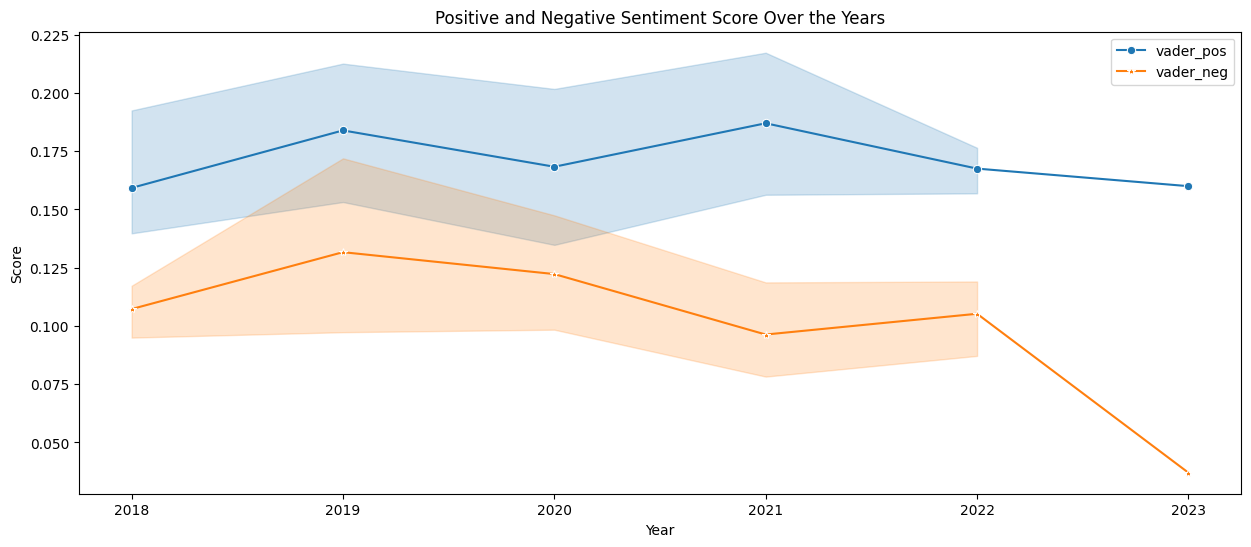

In [23]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=sentiment_results, x="year", y="vader_pos",marker="o", label="vader_pos")
sns.lineplot(data=sentiment_results, x="year", y="vader_neg",marker="*", label="vader_neg")

plt.xlabel("Year")
plt.ylabel("Score")
plt.title("Positive and Negative Sentiment Score Over the Years")
plt.legend()

plt.show()

From the figure we can see that:

* The blue line represents the positive sentiment (vader_pos), which shows a slight upward trend from 2018 to 2021, peaking around 0.20 in 2021, but it steadily declines afterward.

* The red line represents the negative sentiment (vader_neg), which follows a similar trajectory, peaking in 2019 and gradually decreasing, with the lowest negative sentiment score observed in 2023.


## Lexical Diversity

To analyze the diversity in vocabulary of the speeches we can use different measures such as:

* **TTR (Type-Token Ratio)**: Measures vocabulary richness by comparing unique words to the total number of words.

* **MTLD (Measure of Textual Lexical Diversity)**: Evaluates the lexical diversity of the text, resilient to text length variations.

* **HDD (Hypergeometric Distribution D)**: Estimates vocabulary diversity by sampling smaller portions of the text for more stable results.

The results are stored in a dataframe alongside the corresponding year of each speech, providing insight into how lexical diversity varies over time.


In [24]:
def lexical_measures(text):
    ttr_value = ld.ttr(text)
    mtld_value = ld.mtld(text)
    hdd_value = ld.hdd(text)
    
    return ttr_value, mtld_value, hdd_value

In [25]:
lexical_results_dict = {
    "ttr_value" : [],
    "mtld_value" : [],
    "hdd_value" : []
}

diversity = df["tokenized_content"].apply(lexical_measures)

for ttr_value, mtld_value, hdd_value in diversity:
    lexical_results_dict["ttr_value"].append(ttr_value)
    lexical_results_dict["mtld_value"].append(mtld_value)
    lexical_results_dict["hdd_value"].append(hdd_value)

lexical_results = pd.DataFrame(lexical_results_dict)
lexical_results["year"] = df["year"].values

display(lexical_results.head())

,ttr_value,mtld_value,hdd_value,year
0,0.489144,94.269068,0.926053,2021
1,0.481544,121.236373,0.929039,2021
2,0.576659,84.289203,0.911472,2020
3,0.559041,89.686820,0.909882,2019
4,0.519097,94.542630,0.881443,2021


#### Visualizing Lexical Diversity

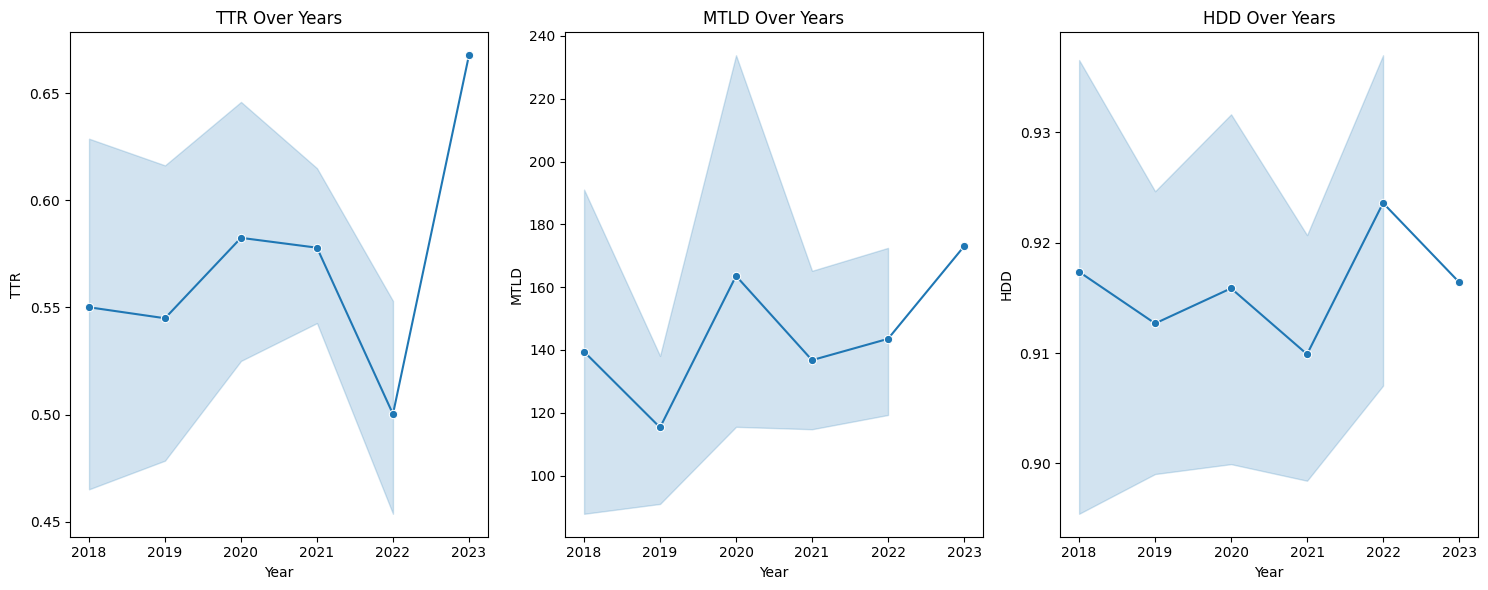

In [26]:
plt.figure(figsize=(15, 6))

# Plot TTR values by year
plt.subplot(1, 3, 1)
sns.lineplot(x='year', y='ttr_value', data=lexical_results, marker='o')
plt.title('TTR Over Years')
plt.xlabel('Year')
plt.ylabel('TTR')

# Plot MTLD values by year
plt.subplot(1, 3, 2)
sns.lineplot(x='year', y='mtld_value', data=lexical_results, marker='o')
plt.title('MTLD Over Years')
plt.xlabel('Year')
plt.ylabel('MTLD')

# Plot HDD values by year
plt.subplot(1, 3, 3)
sns.lineplot(x='year', y='hdd_value', data=lexical_results, marker='o')
plt.title('HDD Over Years')
plt.xlabel('Year')
plt.ylabel('HDD')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

This figure shows three line plots, each representing different lexical diversity measures over the years from 2018 to 2023.

* The TTR values fluctuate between 0.50 and 0.65, with a sharp drop in 2022 and a sudden increase to the highest value in 2023 (~0.65).

* The MTLD score has a sharp peak in 2020 (230) but drops to lower values around 2021, then steadily increases again toward 2023 (200).

* The HDD values show relatively small fluctuations between 0.90 and 0.93, with a significant dip in 2021 followed by an increase in 2022 and slight decline in 2023.
